In [ ]:
# %%

from gensim.models import KeyedVectors
model = KeyedVectors.load('fasttextmodel.kv')

In [ ]:
# %%

import pandas as pd
import numpy as np
import re
import emoji
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Masking
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

print("loading dataset")
# Load Dataset (Assume 'text' and 'label' columns in train and test datasets)
train_df = pd.read_csv('tamil_train.csv')  # Replace with your actual path
test_df = pd.read_csv('test.csv')    # Replace with your actual path

# Updated preprocessing function for Tamil text and emojis
def preprocess_text(text):
    # Remove URLs, mentions, and hashtags
    text = re.sub(r"http\S+|www\S+|@\S+|#\S+", "", text)
    # Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))
    # Retain Tamil characters, remove numbers and special characters
    text = re.sub(r"[^அ-ஔௐ-௺\u0B80-\u0BFF\s]", "", text)
    # Strip extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("Apply preprocessing")
# Apply preprocessing to the dataset
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Tokenization and padding
max_len = 50  # Maximum number of words in a comment (you can adjust this)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])

# Convert text to sequences of word indices
X_train = tokenizer.texts_to_sequences(train_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])

# Pad sequences to ensure uniform input size
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# Labels (Assuming binary classification: 1 for abusive, 0 for non-abusive)
y_train = train_df['labels'].values
y_test = test_df['labels'].values

# Create a mask for the sequences
mask_value = 0  # The value used for padding
X_train_masked = np.where(X_train == mask_value, -1, X_train)  # Replace padding value with -1 for masking
X_test_masked = np.where(X_test == mask_value, -1, X_test)  # Same for test data

# Load FastText Tamil embeddings
#embedding_file = 'cc.ta.300.vec.gz'
#word_vectors = KeyedVectors.load_word2vec_format(embedding_file, binary=False)
print("Create embedding matrix")
# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in model:
        embedding_matrix[idx] = model[word]
    else:
        embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))  # For unknown words

loading dataset
Apply preprocessing
Create embedding matrix


In [ ]:
# %%

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense, Masking
from gensim.models import KeyedVectors
from fuzzywuzzy import fuzz
import tensorflow as tf
# Build the Bi-LSTM Model
model_lstm = Sequential()

# Embedding Layer
model_lstm.add(Embedding(input_dim=vocab_size, 
                         output_dim=embedding_dim, 
                         weights=[embedding_matrix], 
                         input_length=max_len, 
                         trainable=False))  # Pre-trained embeddings are not trainable

# First Bi-LSTM Layer
model_lstm.add(Masking(mask_value=-1))  # Mask the padding value
model_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
model_lstm.add(Dropout(0.6))

# Second Bi-LSTM Layer
model_lstm.add(Bidirectional(LSTM(128, return_sequences=False)))
model_lstm.add(Dropout(0.6))

# Dense Layer for binary classification
model_lstm.add(Dense(1, activation='sigmoid'))

# Compile the Model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the Model
history = model_lstm.fit(X_train_masked, y_train, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate the Model
loss, accuracy = model_lstm.evaluate(X_test_masked, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

C:\Users\adhit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 67s 203ms/step - accuracy: 0.6933 - loss: 0.5907 - val_accuracy: 0.7565 - val_loss: 0.5128
Epoch 2/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.8159 - loss: 0.4349 - val_accuracy: 0.7037 - val_loss: 0.6236
Epoch 3/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 54s 202ms/step - accuracy: 0.8432 - loss: 0.3668 - val_accuracy: 0.7190 - val_loss: 0.6074
Epoch 4/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 56s 208ms/step - accuracy: 0.8755 - loss: 0.3020 - val_accuracy: 0.7232 - val_loss: 0.6811
Epoch 5/5
267/267 ━━━━━━━━━━━━━━━━━━━━ 54s 203ms/step - accuracy: 0.8986 - loss: 0.2517 - val_accuracy: 0.7259 - val_loss: 0.7362
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8142 - loss: 0.4272
Test Accuracy: 81.77%


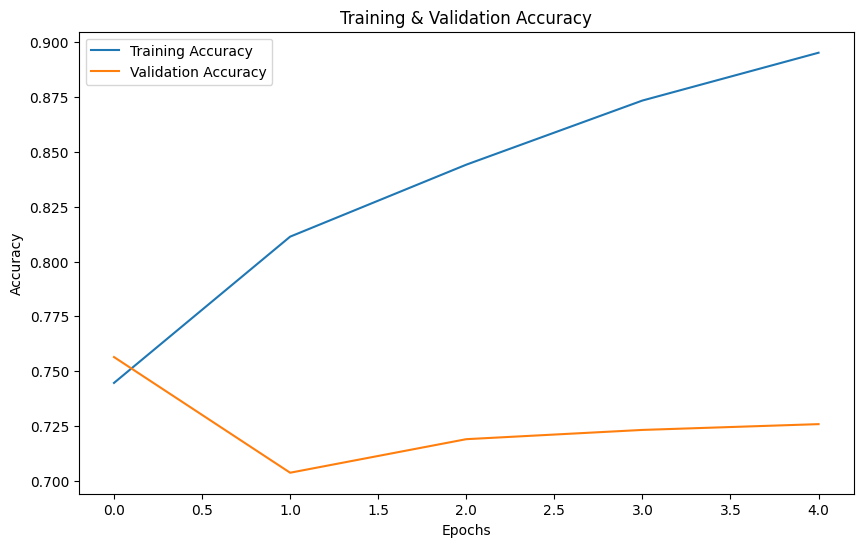

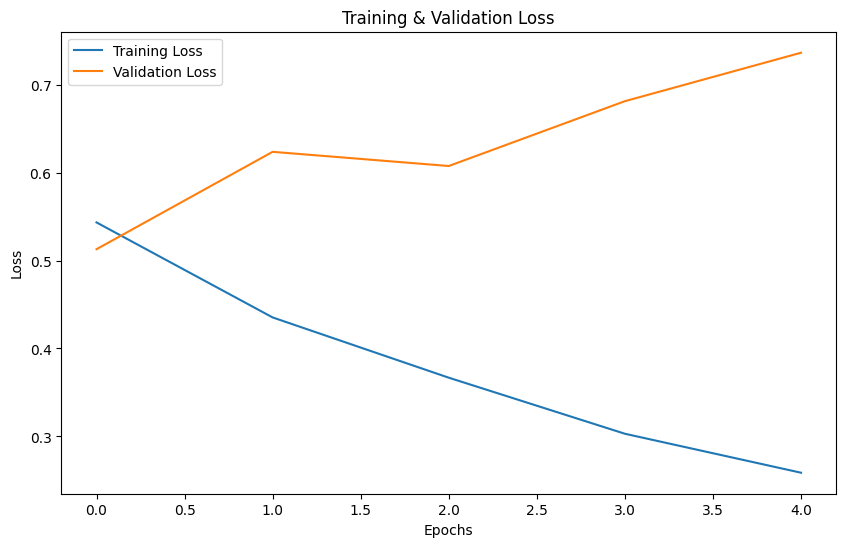

In [ ]:
# %%

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')  # Save accuracy plot

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')  # Save loss plot

In [ ]:
# %%

# Function for post-processing with fuzzy matching
def post_process_predictions(sentences, predictions, abusive_word_list, threshold=0.5, fuzzy_threshold=95):
    for i, sentence in enumerate(sentences):
        if predictions[i] < threshold:  # Predicted as non-abusive
            words = sentence.split()  # Tokenize the sentence into words
            for word in words:
                for abusive_word in abusive_word_list:
                    similarity = fuzz.ratio(word, abusive_word)
                    if similarity >= fuzzy_threshold:  # If a word is close to an abusive word
                        predictions[i] = 1  # Override to abusive
                        print(f"Overriding prediction for '{sentence}' due to fuzzy match with '{abusive_word}'")
                        break
    return predictions

# Load abusive word set
abusive_words_df = pd.read_csv('new_abusive_word_dataset.csv')  # Replace with your actual path
abusive_word_list = abusive_words_df['abusive_words'].tolist()

# Function to adjust predictions based on a threshold
def adjust_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(int)

# Input sentence
input_sentence = "ஏன் மூதாட்டி தேவுடியா"

# Preprocess the input sentence
input_sequence = tokenizer.texts_to_sequences([preprocess_text(input_sentence)])
input_padded = pad_sequences(input_sequence, maxlen=max_len)

# Make predictions using the trained model
input_pred = model_lstm.predict(input_padded)

# Adjust the prediction
input_pred_adjusted = adjust_predictions(input_pred, threshold=0.5)

# Apply post-processing with fuzzy matching
input_pred_final = post_process_predictions([input_sentence], input_pred_adjusted, abusive_word_list)

print(f"Final Prediction for '{input_sentence}': {input_pred_final[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Final Prediction for 'ஏன் மூதாட்டி தேவுடியா': [1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Final Prediction for 'ஏன் மூதாட்டி தேவுடியா': [1]


In [ ]:
# %%

import numpy as np
import pandas as pd
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from keras.preprocessing.sequence import pad_sequences

# Preprocessing function
def preprocess_single_sentence(sentence, tokenizer, max_len):
    # Preprocess text (lowercasing, removing unwanted characters, etc.)
    sentence = preprocess_text(sentence)
    
    # Tokenize the sentence into words (not characters)
    sequence = tokenizer.texts_to_sequences([sentence])
    
    # Pad the sequence to ensure uniform input length
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    
    return padded_sequence


# Function to post-process predictions with fuzzy matching
def post_process_predictions(sentences, predictions, abusive_word_list, threshold=0.5, fuzzy_threshold=95):
    for i, sentence in enumerate(sentences):
        if predictions[i] < threshold:  # Predicted as non-abusive
            words = sentence.split()  # Tokenize the sentence into words
            for word in words:
                for abusive_word in abusive_word_list:
                    similarity = fuzz.ratio(word, abusive_word)
                    if similarity >= fuzzy_threshold:  # If a word is close to an abusive word
                        predictions[i] = 1  # Override to abusive
                        print(f"Overriding prediction for '{sentence}' due to fuzzy match with '{abusive_word}'")
                        break
    return predictions

# Function to adjust predictions based on a threshold
def adjust_predictions(predictions, threshold=0.5):
    return (predictions > threshold).astype(int)

# LIME prediction function (used for LIME explanation)
# LIME prediction function (used for LIME explanation)
# LIME prediction function (used for LIME explanation)
def predict_fn(texts):
    # Preprocess each text in the list
    # This time, ensure the text is tokenized as a whole sentence, not as individual characters
    processed_texts = [preprocess_single_sentence(text, tokenizer, max_len) for text in texts]
    
    # Stack all processed sequences
    processed_texts = np.vstack(processed_texts)
    
    # Make predictions using the model
    preds = model_lstm.predict(processed_texts)
    
    # Convert single class probability to two-class format
    return np.hstack([1 - preds, preds])  # Shape (n_samples, 2) with probabilities for both classes


# LIME explanation function
from lime.lime_text import LimeTextExplainer

def explain_with_lime(sentence, model):
    # Define the class names for the binary classification
    explainer = LimeTextExplainer(class_names=['Non-abusive', 'Abusive'])
    
    # Generate explanation using word-level features
    exp = explainer.explain_instance(
        sentence,  # Input sentence (not tokenized here)
        predict_fn,  # Function that makes predictions
        num_features=10,  # Number of words to highlight in the explanation
        labels=[1]  # Focus on the 'Abusive' class
    )

    # Display explanation in the notebook
    exp.show_in_notebook(text=True)

    # Optional: Save explanation to HTML
    exp.save_to_file('lime_explanation.html')


# Load the abusive word list from a CSV file
abusive_words_df = pd.read_csv('new_abusive_word_dataset.csv')  # Replace with the actual path to your dataset
abusive_word_list = abusive_words_df['abusive_words'].tolist()  # Convert column to a list

# Input sentence to predict
input_sentence = "மட்டமான கேவலமான காரி துப்பற வெளக்கமாத்துள அடிக்கிக்ற நிகழ்ச்சி னா அது பிக் பாஸ் தான் அவன் அவன் வேலை புண்டை ய பாருங்கடா"  # Tamil sentence

# Preprocess the input sentence
input_padded = preprocess_single_sentence(input_sentence, tokenizer, max_len)

# Make predictions using the trained model
input_pred = model_lstm.predict(input_padded)

# Adjust the prediction based on a threshold
input_pred_adjusted = adjust_predictions(input_pred, threshold=0.5)

# Apply post-processing with fuzzy matching
input_pred_final = post_process_predictions([input_sentence], input_pred_adjusted, abusive_word_list)

# Output final prediction
if input_pred_final[0] == 1:
    print(f"Final Prediction for '{input_sentence}': Abusive")
else:
    print(f"Final Prediction for '{input_sentence}': Non-abusive")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Final Prediction for 'மட்டமான கேவலமான காரி துப்பற வெளக்கமாத்துள அடிக்கிக்ற நிகழ்ச்சி னா அது பிக் பாஸ் தான் அவன் அவன் வேலை புண்டை ய பாருங்கடா': Abusive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Final Prediction for 'மட்டமான கேவலமான காரி துப்பற வெளக்கமாத்துள அடிக்கிக்ற நிகழ்ச்சி னா அது பிக் பாஸ் தான் அவன் அவன் வேலை புண்டை ய பாருங்கடா': Abusive
